### Install Libraries
- OpenCV (opencv-python)
- Numpy (numpy)
- Matplotlib (matplotlib)

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


### Utilities

In [3]:

# display image
def imshow(title, img, cmap="gray"):
    plt.figure(); plt.title(title); plt.imshow(img, cmap=cmap); plt.axis("off"); plt.show()

# created: checkerboard + point/line
def make_test_image(h=256, w=256):
    y, x = np.indices((h, w))
    board = ((x//16 + y//16) % 2)*255
    img = board.astype(np.uint8)
    cv2.circle(img, (w//2, h//2), 30, 255, 2)
    cv2.line(img, (10,10), (w-10,h-10), 255, 2)
    return img

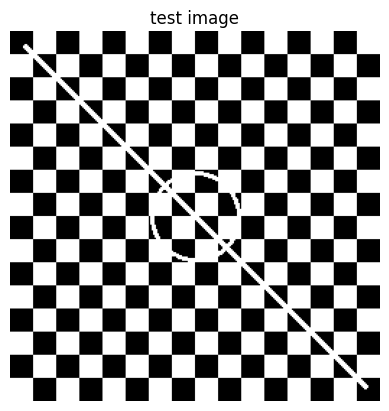

In [4]:
# test image
img = make_test_image()
imshow("test image", img)

### Convolution

#### From scratch(stride=1, same padding)

In [5]:
def conv2d_same(img, kernel):
    kh, kw = kernel.shape # kernel height, width
    pad_h, pad_w = kh//2, kw//2 # same padding
    padded = np.pad(img, ((pad_h,pad_h),(pad_w,pad_w)), mode="constant") # zero padding
    out = np.zeros_like(img, dtype=np.float32) # output array
    
    # convolution operation
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+kh, j:j+kw] # image region
            out[i,j] = np.sum(region * kernel) # element-wise multiplication and sum
  
    # clip to valid range [0, 255] and convert to uint8
    return np.clip(out, 0, 255).astype(np.uint8)

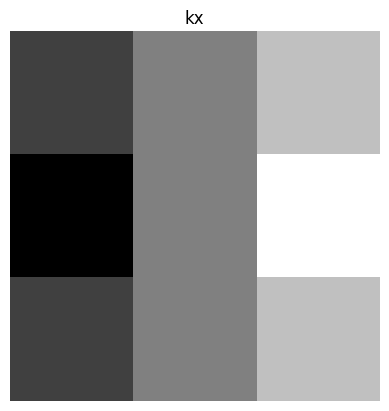

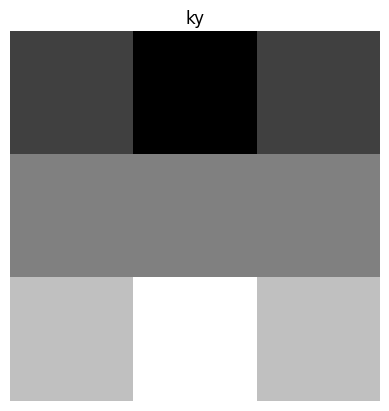

In [6]:
# try edge kernel (Sobel-ish)
kx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=np.float32) 
ky = kx.T

# display kernels
imshow("kx", kx, cmap="gray")
imshow("ky", ky, cmap="gray")

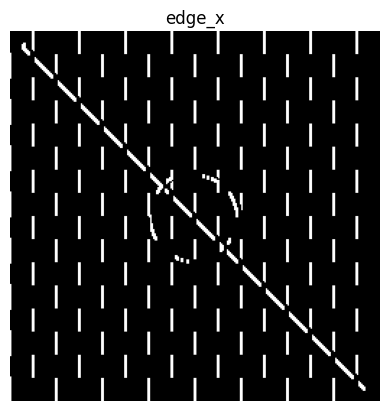

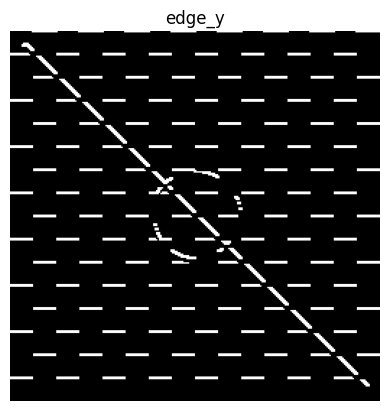

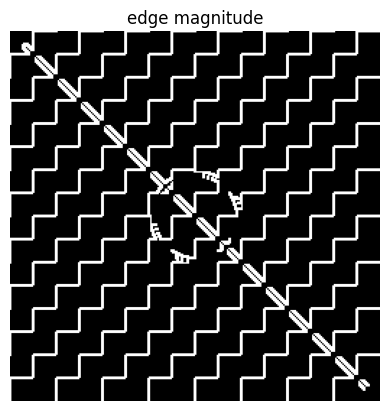

In [7]:
edge_x = conv2d_same(img, kx) # horizontal edges
edge_y = conv2d_same(img, ky) # vertical edges
edge = np.clip(np.hypot(edge_x, edge_y), 0, 255).astype(np.uint8)  # edge magnitude
imshow("edge_x", edge_x); imshow("edge_y", edge_y); imshow("edge magnitude", edge)

#### OpenCV (Filter2D)

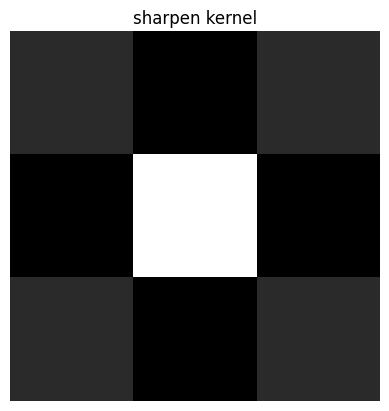

In [8]:

sharp_kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]], np.float32) # sharpen

# display kernel
imshow("sharpen kernel", sharp_kernel, cmap="gray")

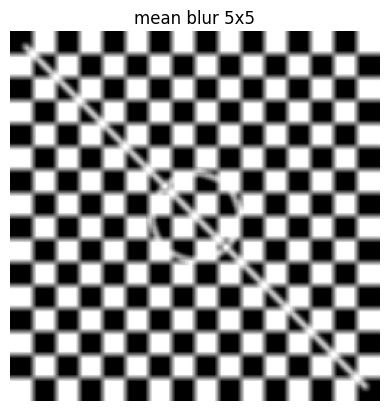

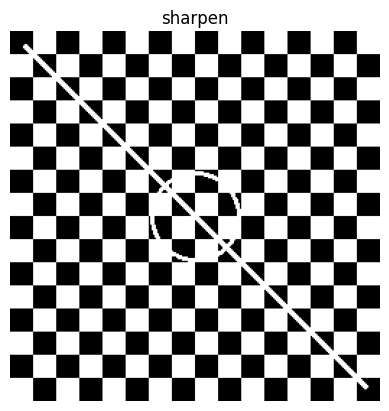

In [9]:
blur = cv2.filter2D(img, -1, np.ones((5,5), np.float32)/25.0)  # mean blur
sharp = cv2.filter2D(img, -1, sharp_kernel) # sharpen
imshow("mean blur 5x5", blur); imshow("sharpen", sharp)

### Pooling

#### Max / Average Pooling From Scratch

In [10]:
def pool2d(img, size=2, stride=2, mode="max"):
    H, W = img.shape
    out_h = (H - size)//stride + 1 # output height
    out_w = (W - size)//stride + 1 # output width
    out = np.zeros((out_h, out_w), dtype=np.float32) # output array

    # pooling operation
    for i in range(out_h):
        for j in range(out_w):
            patch = img[i*stride:i*stride+size, j*stride:j*stride+size] # image patch
            out[i,j] = patch.max() if mode=="max" else patch.mean() # max or average
    return out.astype(np.uint8)

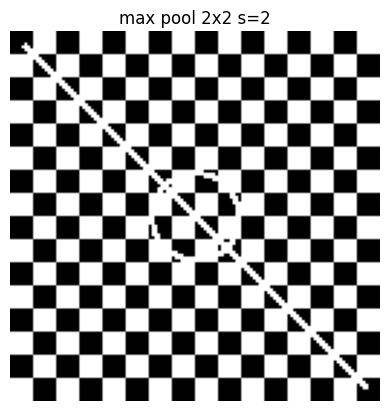

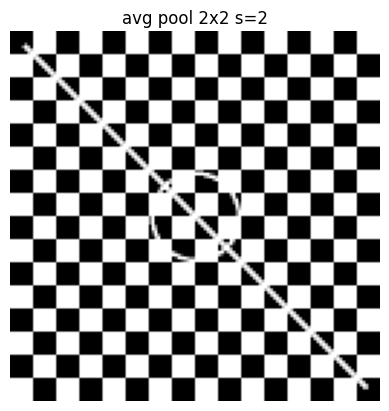

In [11]:
maxp = pool2d(img, size=2, stride=2, mode="max")
avgp = pool2d(img, size=2, stride=2, mode="avg")
imshow("max pool 2x2 s=2", maxp); imshow("avg pool 2x2 s=2", avgp)

#### Approx “average pooling” with cv2.resize()

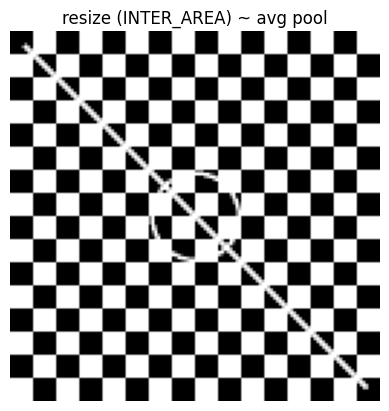

In [12]:
avg_like = cv2.resize(img, (img.shape[1]//2, img.shape[0]//2), interpolation=cv2.INTER_AREA) # resize with INTER_AREA
imshow("resize (INTER_AREA) ~ avg pool", avg_like)

### Affine Transform

- Affine is 𝑦 = 𝐴𝑥 + 𝑏 (A: 2×2 scale/rotate/shear, b: translation 2×1)
- OpenCV using 2×3: [A | b] then cv.warpAffine()

#### Rotate + Scale

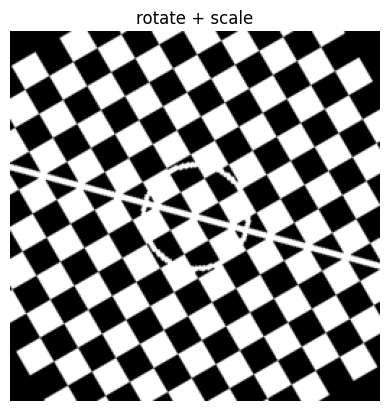

In [13]:
h, w = img.shape
M = cv2.getRotationMatrix2D(center=(w//2, h//2), angle=30, scale=1.2)
rot = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
imshow("rotate + scale", rot)

#### Translation + Shear

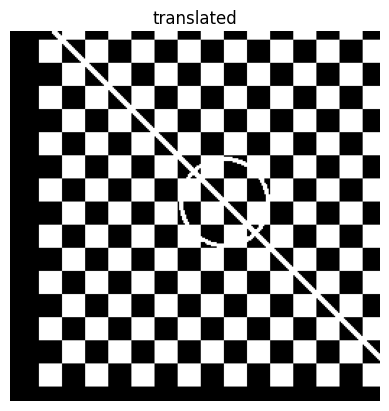

In [14]:
# Translation b=(tx, ty)
tx, ty = 20, -10
M_trans = np.array([[1, 0, tx],
                    [0, 1, ty]], dtype=np.float32)
shifted = cv2.warpAffine(img, M_trans, (w, h))
imshow("translated", shifted)

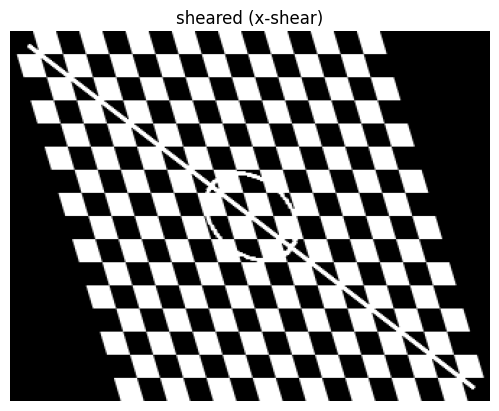

In [15]:
# Shear 𝑦 = [1 k; 0 1]x
k = 0.3
A = np.array([[1, k],
              [0, 1]], dtype=np.float32)
M_shear = np.hstack([A, np.array([[0],[0]], np.float32)])
sheared = cv2.warpAffine(img, M_shear, (w + int(k*h), h))
imshow("sheared (x-shear)", sheared)

#### From–to mapping

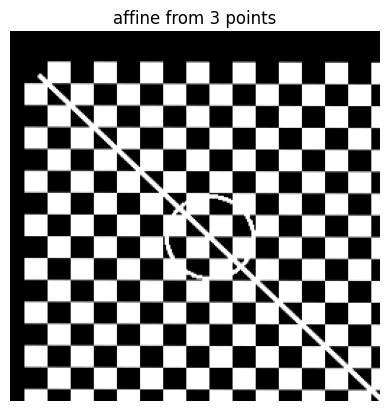

In [16]:
src = np.float32([[20,20],[200,30],[30,200]])
dst = np.float32([[30,40],[210,50],[40,210]])
M_aff = cv2.getAffineTransform(src, dst)
aff = cv2.warpAffine(img, M_aff, (w, h))
imshow("affine from 3 points", aff)